## **PH451 Final Project: Dark Matter Substructure Classification Using Simulated Lensing Images**

### Group 6: Zach Feller, Devin Kodsi, Thanh Nguyen

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from typing import Tuple, Union

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import DatasetFolder

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

torch.cuda.empty_cache()
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1/ Data Preprocessing**

In [2]:
# Define a function to get, min-max normalize, and reshape the data
def get_data(file_path):
    sample = np.load(file_path, allow_pickle=True)

    # Check if 'axion' is in the file path
    if 'axion' in file_path:
        sample = sample[0]  # Assuming 'axion' data needs to extract the first element

    # Min-Max normalization
    sample = (sample - np.amin(sample)) / (np.amax(sample) - np.amin(sample))
    sample = sample.reshape(1, 64, 64)  # Reshape the sample
    
    return torch.from_numpy(sample).float()  # Convert to torch.Tensor and ensure dtype is float

# Define the transformations
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to(torch.float32))
])

# Path to the dataset
root = './Model_III'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=root,
    loader=get_data,
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=f'{root}_test',
    loader=get_data,
    extensions='npy',
    transform=transform
)

# Split the train dataset to get the validation dataset with ratio 90:10
train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1])

# Set the batch size
batch_size = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print some information about the data
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 80457
Validation dataset size: 8939
Test dataset size: 15000
Image shape: torch.Size([1, 64, 64])
Classes: ['axion', 'cdm', 'no_sub']
Image tensor type: torch.float32
Batches: 805


#### Visualize some examples

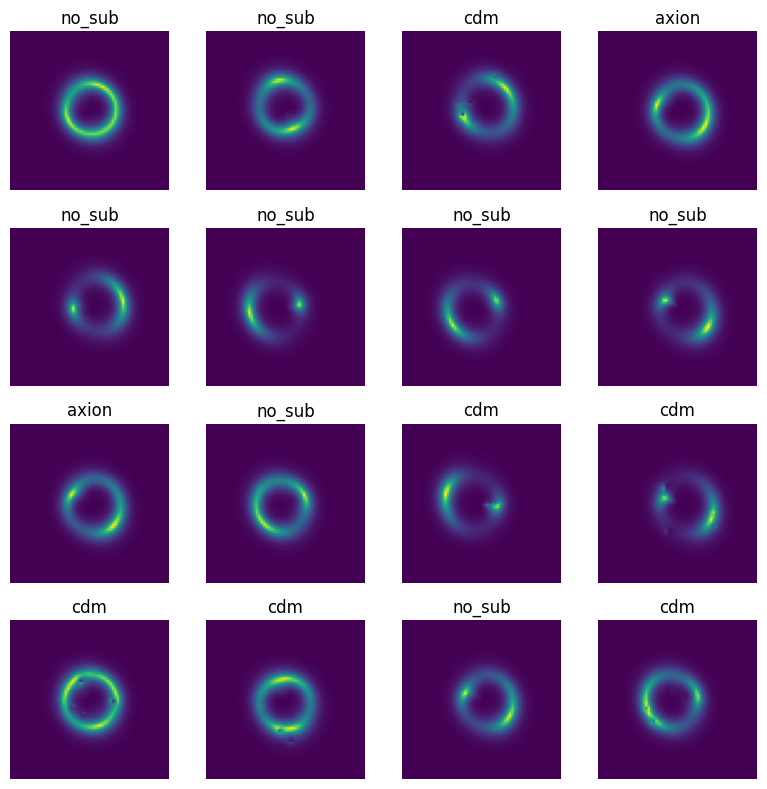

In [46]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

#### Define the train and test functions

In [4]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=200, save_path='./model_name.pt'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    } # Initialize a dictionary to store epoch-wise results
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
            f"Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, "
            f"Val Acc: {val_acc:.4f}, LR: {scheduler.get_last_lr()}"
        )

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save the parameters with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

    return history, model

In [5]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_corrects += torch.sum(preds == labels).item()

            y_pred_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])
    classes = ['axion', 'cdm', 'no_sub']

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], np.array(y_pred_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Average ROC AUC score
    avg_roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovo')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {avg_roc_auc:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, label=f'{classes[i]}: {roc_auc[i]:0.4f}')
    avg_fpr, avg_tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(avg_fpr, avg_tpr, color='orange', linestyle='--', label=f'macro-avg: {avg_roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [6]:
def plot_results(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

### **2/ Training and validation**

#### Declare the models

In [7]:
# Initialize the CNN model
cnn = nn.Sequential()
cnn.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, stride=2, padding=3))
cnn.append(nn.ReLU(inplace=True))
cnn.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=3))
cnn.append(nn.ReLU(inplace=True))
cnn.append(nn.MaxPool2d(kernel_size=(2, 2)))
cnn.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2))
cnn.append(nn.ReLU(inplace=True))
cnn.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2))
cnn.append(nn.ReLU(inplace=True))
cnn.append(nn.MaxPool2d(kernel_size=(2, 2)))
cnn.append(nn.Flatten())
cnn.append(nn.Linear(4608, 64))  # Got 4608 from an error message
cnn.append(nn.ReLU(inplace=True))
cnn.append(nn.Dropout(0.2))
cnn.append(nn.Linear(64, 32))
cnn.append(nn.ReLU(inplace=True))
cnn.append(nn.Dropout(0.2))
cnn.append(nn.Linear(32, 3))
cnn.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU(inplace=True)
  (2): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (6): ReLU(inplace=True)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=4608, out_features=64, bias=True)
  (12): ReLU(inplace=True)
  (13): Dropout(p=0.2, inplace=False)
  (14): Linear(in_features=64, out_features=32, bias=True)
  (15): ReLU(inplace=True)
  (16): Dropout(p=0.2, inplace=False)
  (17): Linear(in_features=32, out_features=3, bias=True)
)

In [8]:
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()

# Train the model
history_cnn, cnn = train_model(cnn, criterion, optimizer, scheduler, num_epochs=100, save_path='./cnn.pt')

Epoch [1/100], Train Loss: 0.9281, Train Acc: 0.5125, Val Loss: 0.5400, Val Acc: 0.7935, LR: [0.0001]
Epoch [2/100], Train Loss: 0.5317, Train Acc: 0.7983, Val Loss: 0.3522, Val Acc: 0.8812, LR: [8.8648439016413e-05]
Epoch [3/100], Train Loss: 0.4505, Train Acc: 0.8303, Val Loss: 0.3245, Val Acc: 0.8790, LR: [9.244273690228372e-05]
Epoch [4/100], Train Loss: 0.3971, Train Acc: 0.8503, Val Loss: 0.3413, Val Acc: 0.8689, LR: [9.301473905218641e-05]
Epoch [5/100], Train Loss: 0.3753, Train Acc: 0.8574, Val Loss: 0.2900, Val Acc: 0.8938, LR: [9.266769098553715e-05]
Epoch [6/100], Train Loss: 0.3568, Train Acc: 0.8630, Val Loss: 0.2743, Val Acc: 0.8926, LR: [9.373321547479276e-05]
Epoch [7/100], Train Loss: 0.3336, Train Acc: 0.8701, Val Loss: 0.2678, Val Acc: 0.8931, LR: [9.406206015548447e-05]
Epoch [8/100], Train Loss: 0.3237, Train Acc: 0.8724, Val Loss: 0.2681, Val Acc: 0.8917, LR: [9.419946869866782e-05]
Epoch [9/100], Train Loss: 0.3128, Train Acc: 0.8759, Val Loss: 0.2438, Val Acc: 

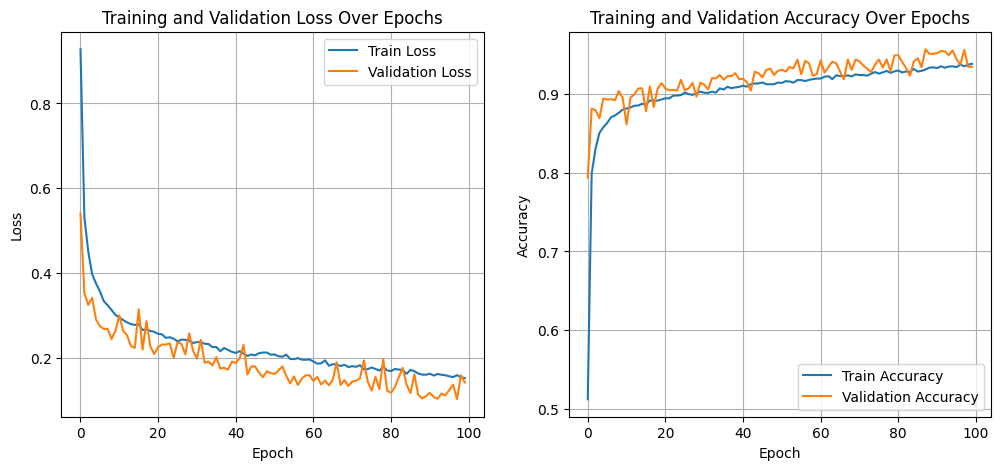

In [10]:
# Training progress of CNN
plot_results(history_cnn)

In [11]:
# Load checkpoint
cnn.load_state_dict(torch.load('./cnn.pt'))

<All keys matched successfully>

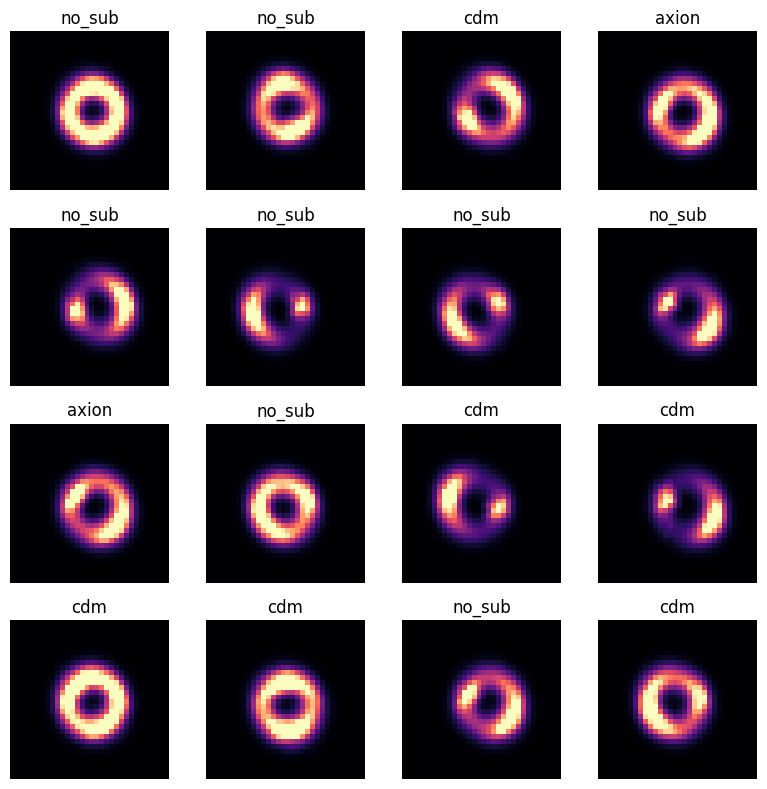

In [47]:
# Visualize the first channel in the first convolution for some images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        if i < 16:
            image, label = images[i], labels[i]
            image = cnn[0](image.unsqueeze(0).to(device)).cpu()
            img = image[0][0].detach().numpy()
            img = np.clip(img, 0, 1)

            ax.imshow(img, cmap='magma')
            ax.set_title(train_dataset.dataset.classes[label])
            ax.axis('off')
        else:
            break

plt.tight_layout()
plt.show()

Test Loss: 0.1161
Accuracy: 0.9555
ROC AUC: 0.9956


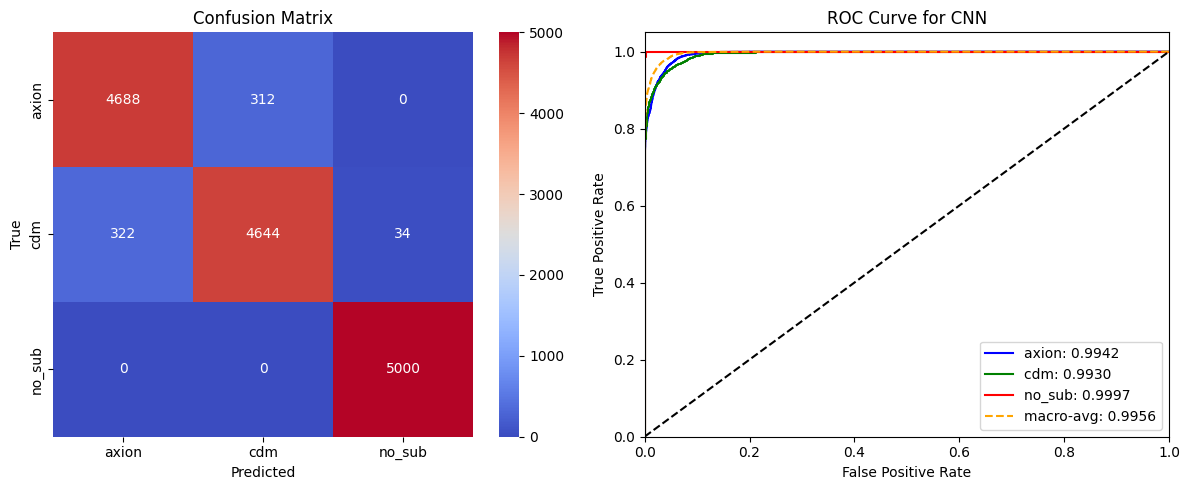

In [12]:
# Evaluate the model
evaluate_model(cnn, criterion, 'CNN')

In [13]:
# Initialize ResNet18 with pre-trained weights
resnet18 = models.resnet18(weights=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # 1 channel
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 3)  # 3 classes
resnet18.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
optimizer = optim.Adam(resnet18.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()

# Train the model
history_resnet, resnet18 = train_model(resnet18, criterion, optimizer, scheduler, num_epochs=100, save_path='./resnet18.pt')

Epoch [1/100], Train Loss: 0.5461, Train Acc: 0.7755, Val Loss: 0.3370, Val Acc: 0.8606, LR: [1e-05]
Epoch [2/100], Train Loss: 0.2963, Train Acc: 0.8824, Val Loss: 0.2647, Val Acc: 0.8905, LR: [9.275605111430345e-06]
Epoch [3/100], Train Loss: 0.2334, Train Acc: 0.9064, Val Loss: 0.2138, Val Acc: 0.9111, LR: [9.4264322400188e-06]
Epoch [4/100], Train Loss: 0.1927, Train Acc: 0.9216, Val Loss: 0.2239, Val Acc: 0.9078, LR: [9.534186527689782e-06]
Epoch [5/100], Train Loss: 0.1729, Train Acc: 0.9316, Val Loss: 0.2071, Val Acc: 0.9190, LR: [9.512707234805224e-06]
Epoch [6/100], Train Loss: 0.1529, Train Acc: 0.9392, Val Loss: 0.2012, Val Acc: 0.9227, LR: [9.548327722320118e-06]
Epoch [7/100], Train Loss: 0.1350, Train Acc: 0.9471, Val Loss: 0.1901, Val Acc: 0.9242, LR: [9.561008030531396e-06]
Epoch [8/100], Train Loss: 0.1232, Train Acc: 0.9522, Val Loss: 0.1802, Val Acc: 0.9300, LR: [9.584577398083408e-06]
Epoch [9/100], Train Loss: 0.1101, Train Acc: 0.9580, Val Loss: 0.1490, Val Acc: 0

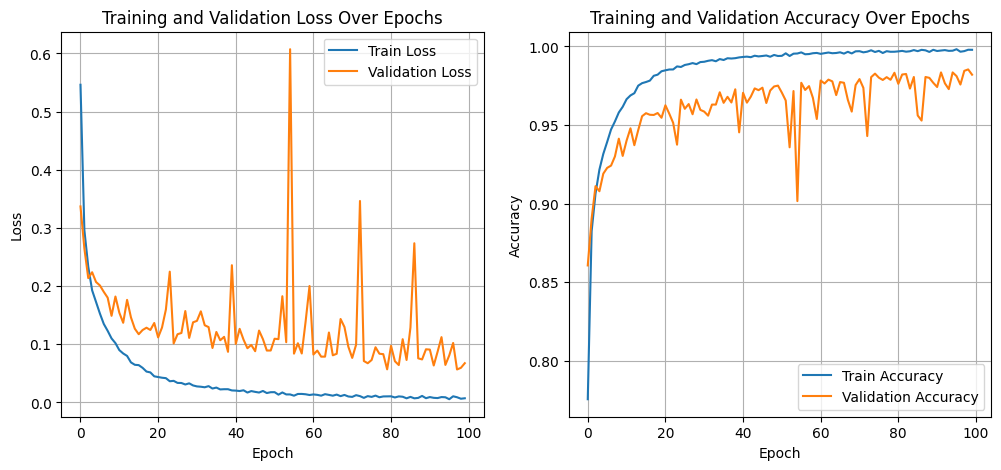

In [16]:
# Training progress of ResNet18
plot_results(history_resnet)

In [17]:
# Load checkpoint
resnet18.load_state_dict(torch.load('./resnet18.pt'))

<All keys matched successfully>

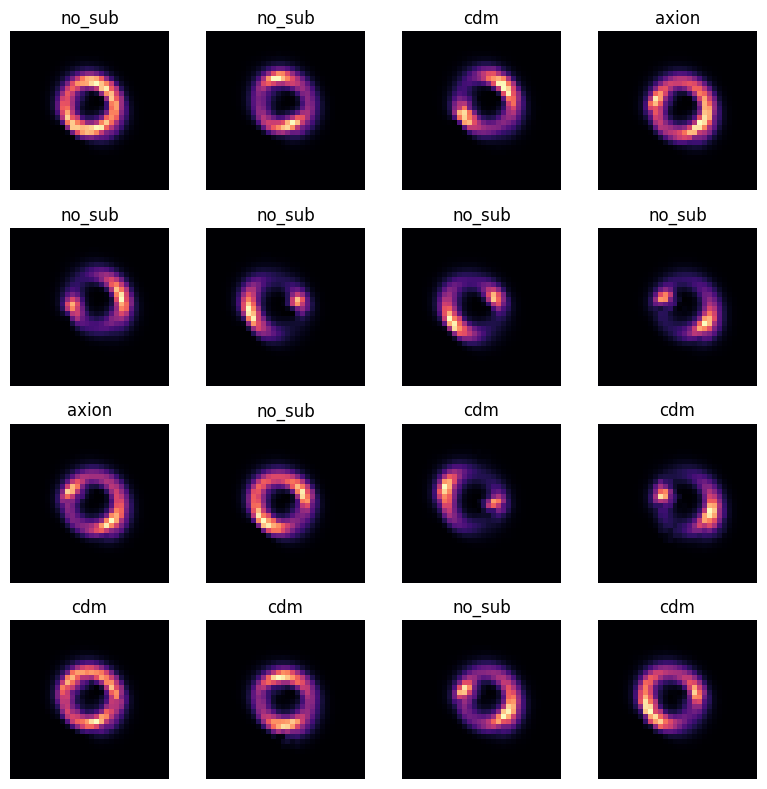

In [48]:
# Visualize the first channel in the first convolution for some images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        if i < 16:
            image, label = images[i], labels[i]
            image = resnet18.conv1(image.unsqueeze(0).to(device)).cpu()
            img = image[0][0].detach().numpy()
            img = np.clip(img, 0, 1)

            ax.imshow(img, cmap='magma')
            ax.set_title(train_dataset.dataset.classes[label])
            ax.axis('off')
        else:
            break

plt.tight_layout()
plt.show()

Test Loss: 0.0658
Accuracy: 0.9828
ROC AUC: 0.9989


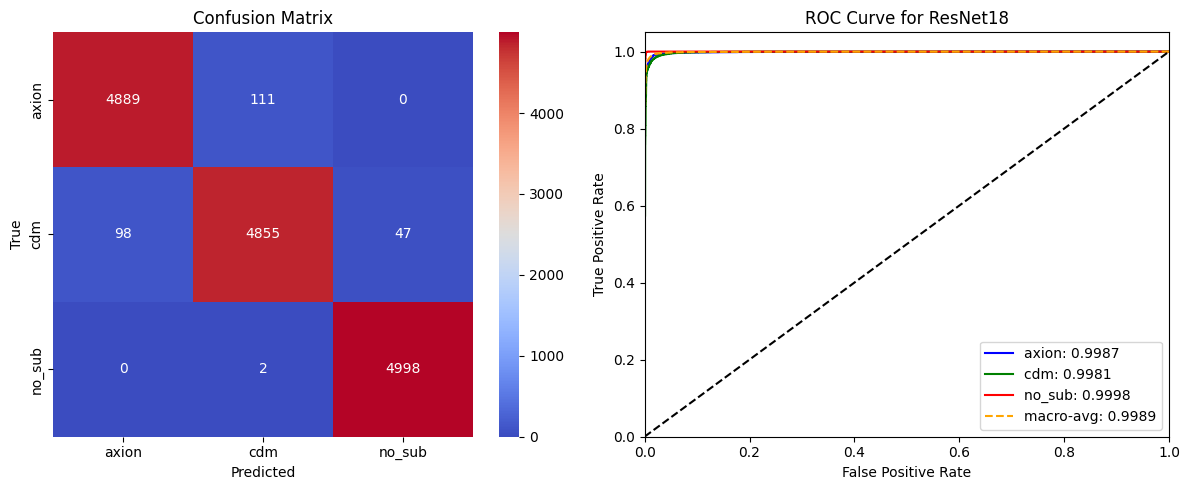

In [18]:
# Evaluate the model
evaluate_model(resnet18, criterion, 'ResNet18')

In [21]:
# Initialize EfficientNet_B0 with pre-trained weights
effnet = models.efficientnet_b0(weights=True)
effnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)  # 1 channel
effnet.classifier[1] = torch.nn.Linear(effnet.classifier[1].in_features, 3)  # 3 classes
effnet.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
optimizer = optim.Adam(effnet.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()

# Train the model
history_effnet, effnet = train_model(effnet, criterion, optimizer, scheduler, num_epochs=100, save_path='./efficientnet_b0.pt')

Epoch [1/100], Train Loss: 0.9756, Train Acc: 0.5259, Val Loss: 0.7433, Val Acc: 0.7729, LR: [1e-05]
Epoch [2/100], Train Loss: 0.6679, Train Acc: 0.7453, Val Loss: 0.4882, Val Acc: 0.8624, LR: [8.471692657938172e-06]
Epoch [3/100], Train Loss: 0.4658, Train Acc: 0.8294, Val Loss: 0.4670, Val Acc: 0.8927, LR: [8.967841963561599e-06]
Epoch [4/100], Train Loss: 0.3607, Train Acc: 0.8669, Val Loss: 0.3429, Val Acc: 0.9181, LR: [9.010289557939397e-06]
Epoch [5/100], Train Loss: 0.2929, Train Acc: 0.8902, Val Loss: 1.9021, Val Acc: 0.9325, LR: [9.263309510730734e-06]
Epoch [6/100], Train Loss: 0.2555, Train Acc: 0.9036, Val Loss: 0.2302, Val Acc: 0.9375, LR: [6.541324610489893e-06]
Epoch [7/100], Train Loss: 0.2265, Train Acc: 0.9151, Val Loss: 0.1892, Val Acc: 0.9480, LR: [9.49927643572341e-06]
Epoch [8/100], Train Loss: 0.1989, Train Acc: 0.9258, Val Loss: 0.5571, Val Acc: 0.9526, LR: [9.586561025999059e-06]
Epoch [9/100], Train Loss: 0.1771, Train Acc: 0.9344, Val Loss: 0.3601, Val Acc: 

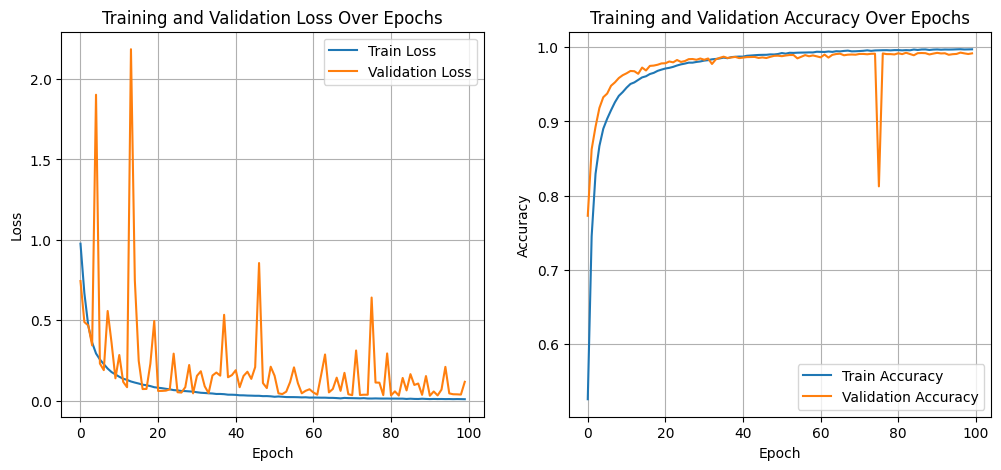

In [24]:
# Training progress of EfficientNet_B0
plot_results(history_effnet)

In [25]:
# Load checkpoint
effnet.load_state_dict(torch.load('./efficientnet_b0.pt'))

<All keys matched successfully>

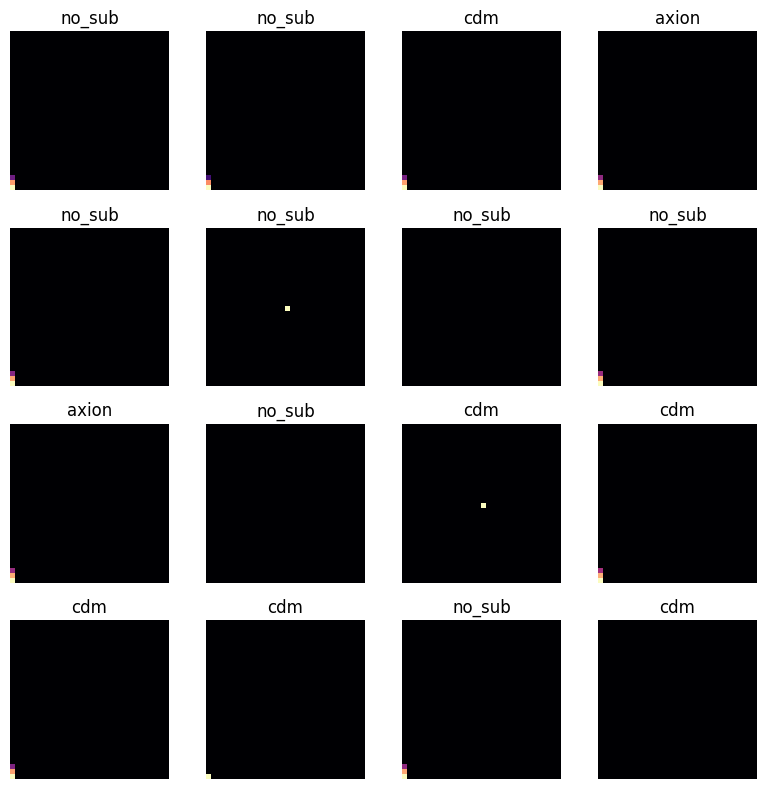

In [49]:
# Visualize the first channel in the first convolution for some images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        if i < 16:
            image, label = images[i], labels[i]
            image = effnet.features[0][0](image.unsqueeze(0).to(device)).cpu()
            img = image[0][0].detach().numpy()
            img = np.clip(img, 0, 1)

            ax.imshow(img, cmap='magma')
            ax.set_title(train_dataset.dataset.classes[label])
            ax.axis('off')
        else:
            break

plt.tight_layout()
plt.show()

Test Loss: 0.0791
Accuracy: 0.9917
ROC AUC: 0.9994


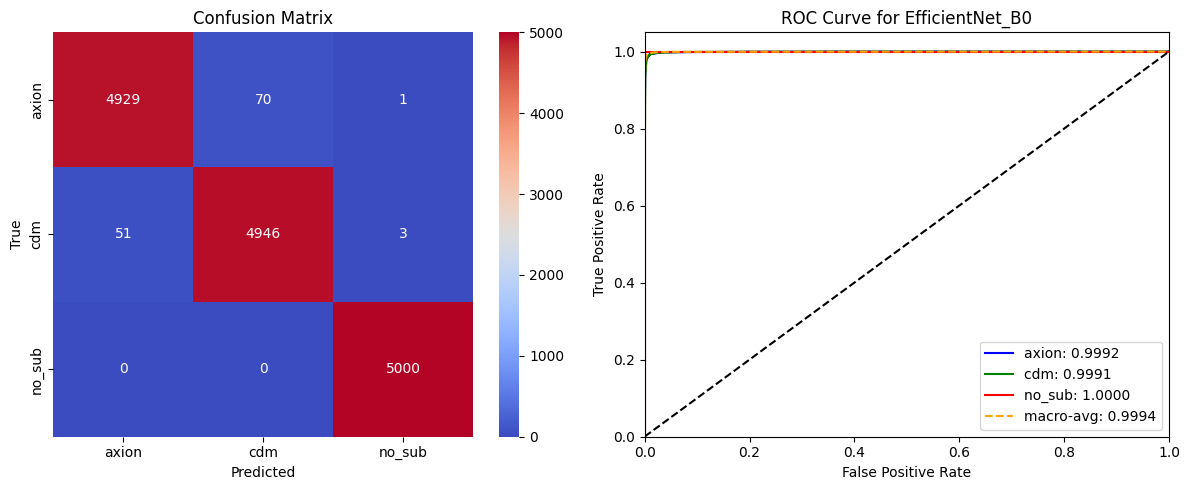

In [26]:
# Evaluate the model
evaluate_model(effnet, criterion, 'EfficientNet_B0')

In [27]:
# Vision transformer
from vit_pytorch import ViT

v = ViT(
    image_size=64,
    channels=1,
    patch_size=32,
    num_classes=3,
    dim=384,
    depth=6,
    heads=16,
    mlp_dim=768,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

v

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=1024, out_features=384, bias=True)
    (3): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=384, out_features=3072, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=384, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
           

In [28]:
optimizer = optim.Adam(v.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()

# Train the vision transformer
history_v, v = train_model(v, criterion, optimizer, scheduler, num_epochs=100, save_path='./ViT.pt')

Epoch [1/100], Train Loss: 0.7175, Train Acc: 0.6540, Val Loss: 0.3935, Val Acc: 0.8373, LR: [1e-05]
Epoch [2/100], Train Loss: 0.4729, Train Acc: 0.7994, Val Loss: 0.3888, Val Acc: 0.8317, LR: [9.159436871246576e-06]
Epoch [3/100], Train Loss: 0.4330, Train Acc: 0.8185, Val Loss: 0.3875, Val Acc: 0.8340, LR: [9.169039528639562e-06]
Epoch [4/100], Train Loss: 0.4066, Train Acc: 0.8303, Val Loss: 0.3341, Val Acc: 0.8549, LR: [9.171686101974445e-06]
Epoch [5/100], Train Loss: 0.3900, Train Acc: 0.8384, Val Loss: 0.3392, Val Acc: 0.8549, LR: [9.281683674226252e-06]
Epoch [6/100], Train Loss: 0.3733, Train Acc: 0.8465, Val Loss: 0.3333, Val Acc: 0.8588, LR: [9.270939144614267e-06]
Epoch [7/100], Train Loss: 0.3603, Train Acc: 0.8520, Val Loss: 0.3194, Val Acc: 0.8633, LR: [9.283262007523905e-06]
Epoch [8/100], Train Loss: 0.3544, Train Acc: 0.8534, Val Loss: 0.3338, Val Acc: 0.8602, LR: [9.312131594105372e-06]
Epoch [9/100], Train Loss: 0.3456, Train Acc: 0.8564, Val Loss: 0.3033, Val Acc:

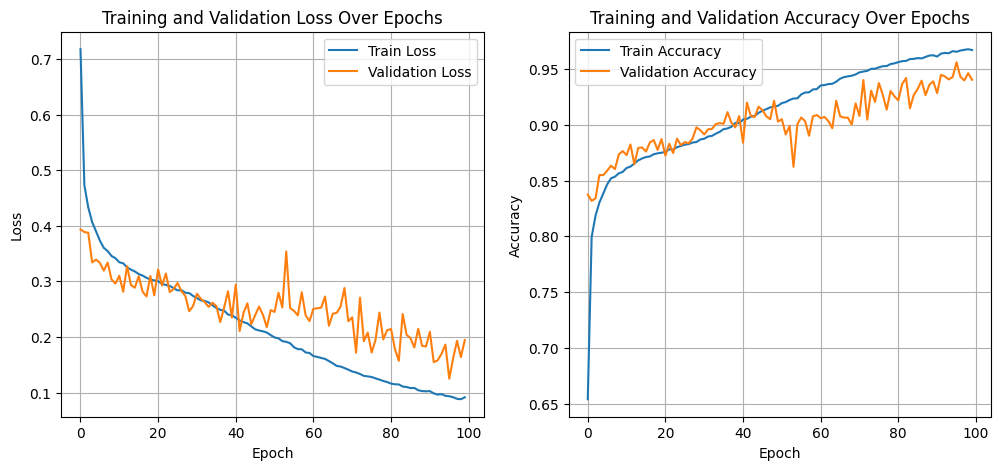

In [29]:
# Training progress of Vision Transformer
plot_results(history_v)

In [30]:
# Load checkpoint
v.load_state_dict(torch.load('./ViT.pt'))

<All keys matched successfully>

Test Loss: 0.1392
Accuracy: 0.9525
ROC AUC: 0.9984


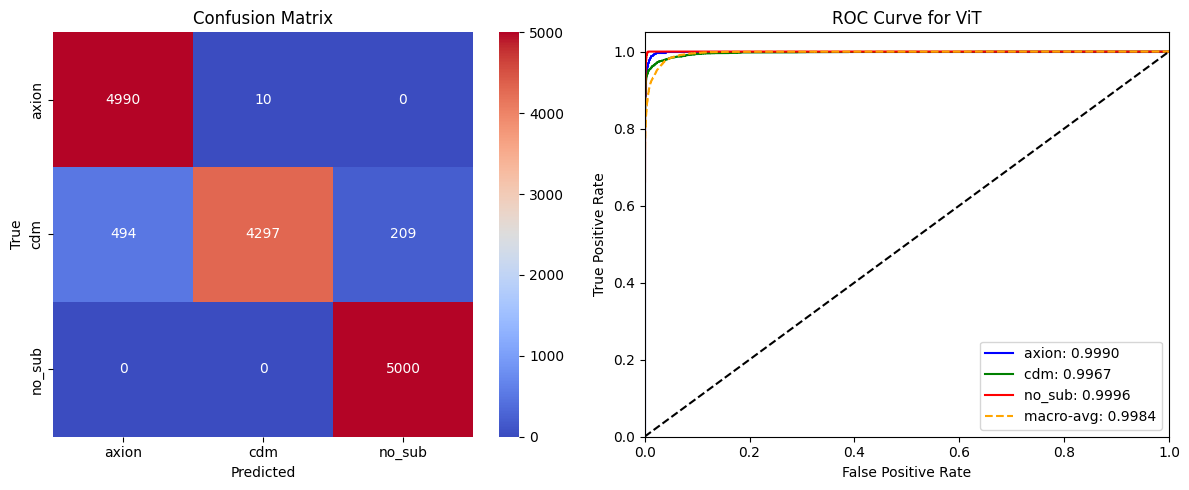

In [31]:
# Evaluate the model
evaluate_model(v, criterion, 'ViT')

In [32]:
# Convolutional vision transformer
from vit_pytorch.cvt import CvT

cvt = CvT(
    num_classes=3,
    channels=1,
    s1_emb_dim=54,        # stage 1 - dimension
    s1_emb_kernel=7,      # stage 1 - conv kernel
    s1_emb_stride=4,      # stage 1 - conv stride
    s1_proj_kernel=3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride=2,  # stage 1 - attention key / value projection stride
    s1_heads=1,           # stage 1 - heads
    s1_depth=1,           # stage 1 - depth
    s1_mlp_mult=4,        # stage 1 - feedforward expansion factor
    s2_emb_dim=162,       # stage 2 - (same as above)
    s2_emb_kernel=3,
    s2_emb_stride=2,
    s2_proj_kernel=3,
    s2_kv_proj_stride=2,
    s2_heads=3,
    s2_depth=2,
    s2_mlp_mult=4,
    s3_emb_dim=324,       # stage 3 - (same as above)
    s3_emb_kernel=3,
    s3_emb_stride=2,
    s3_proj_kernel=3,
    s3_kv_proj_stride=2,
    s3_heads=4,
    s3_depth=10,
    s3_mlp_mult=4,
    dropout=0.
).to(device)

cvt

CvT(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 54, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (1): LayerNorm()
      (2): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): Attention(
              (norm): LayerNorm()
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_q): DepthWiseConv2d(
                (net): Sequential(
                  (0): Conv2d(54, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=54, bias=False)
                  (1): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): Conv2d(54, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (to_kv): DepthWiseConv2d(
                (net): Sequential(
                  (0): Conv2d(54, 54, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=54, bias=False)
                  

In [33]:
optimizer = optim.Adam(cvt.parameters(), lr=1e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()

# Train the model
history_cvt, cvt = train_model(cvt, criterion, optimizer, scheduler, num_epochs=100, save_path='./CvT.pt')

Epoch [1/100], Train Loss: 0.7980, Train Acc: 0.6653, Val Loss: 0.4725, Val Acc: 0.8164, LR: [1e-06]
Epoch [2/100], Train Loss: 0.4116, Train Acc: 0.8348, Val Loss: 0.3791, Val Acc: 0.8433, LR: [8.999379731842098e-07]
Epoch [3/100], Train Loss: 0.3403, Train Acc: 0.8588, Val Loss: 0.2986, Val Acc: 0.8788, LR: [9.188828564883736e-07]
Epoch [4/100], Train Loss: 0.3115, Train Acc: 0.8706, Val Loss: 0.2783, Val Acc: 0.8899, LR: [9.355455410741618e-07]
Epoch [5/100], Train Loss: 0.2946, Train Acc: 0.8772, Val Loss: 0.2613, Val Acc: 0.8868, LR: [9.397779938300029e-07]
Epoch [6/100], Train Loss: 0.2805, Train Acc: 0.8828, Val Loss: 0.2572, Val Acc: 0.8978, LR: [9.433524845693647e-07]
Epoch [7/100], Train Loss: 0.2709, Train Acc: 0.8863, Val Loss: 0.2655, Val Acc: 0.8916, LR: [9.442283998026539e-07]
Epoch [8/100], Train Loss: 0.2646, Train Acc: 0.8889, Val Loss: 0.2795, Val Acc: 0.8851, LR: [9.424747404980154e-07]
Epoch [9/100], Train Loss: 0.2552, Train Acc: 0.8933, Val Loss: 0.2249, Val Acc:

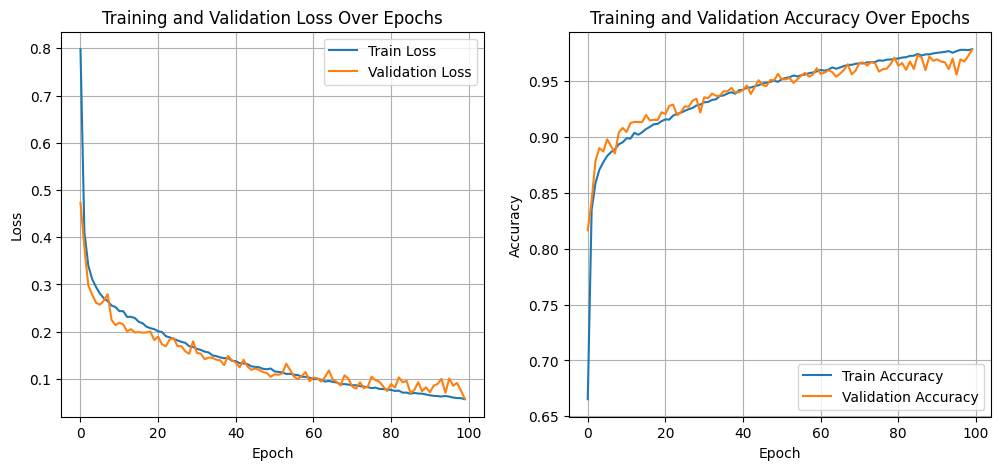

In [35]:
# Training progress of Convolutional Vision Transformer
plot_results(history_cvt)

In [36]:
# Load checkpoint
cvt.load_state_dict(torch.load('./CvT.pt'))

<All keys matched successfully>

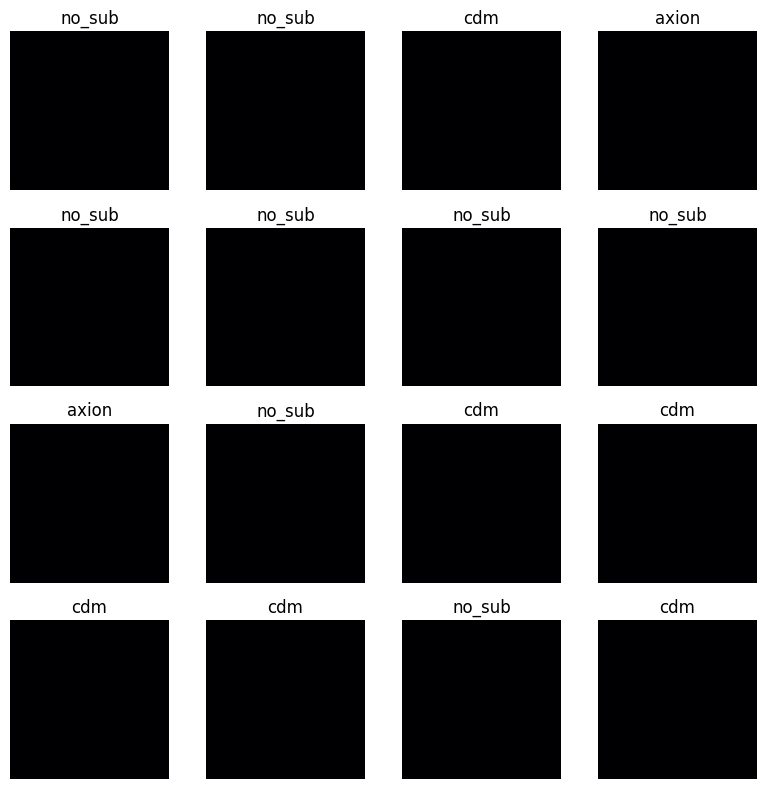

In [50]:
# Visualize the first channel in the first convolution for some images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        if i < 16:
            image, label = images[i], labels[i]
            image = cvt.layers[0][0](image.unsqueeze(0).to(device)).cpu()
            img = image[0][0].detach().numpy()
            img = np.clip(img, 0, 1)

            ax.imshow(img, cmap='magma')
            ax.set_title(train_dataset.dataset.classes[label])
            ax.axis('off')
        else:
            break

plt.tight_layout()
plt.show()

Test Loss: 0.0624
Accuracy: 0.9785
ROC AUC: 0.9985


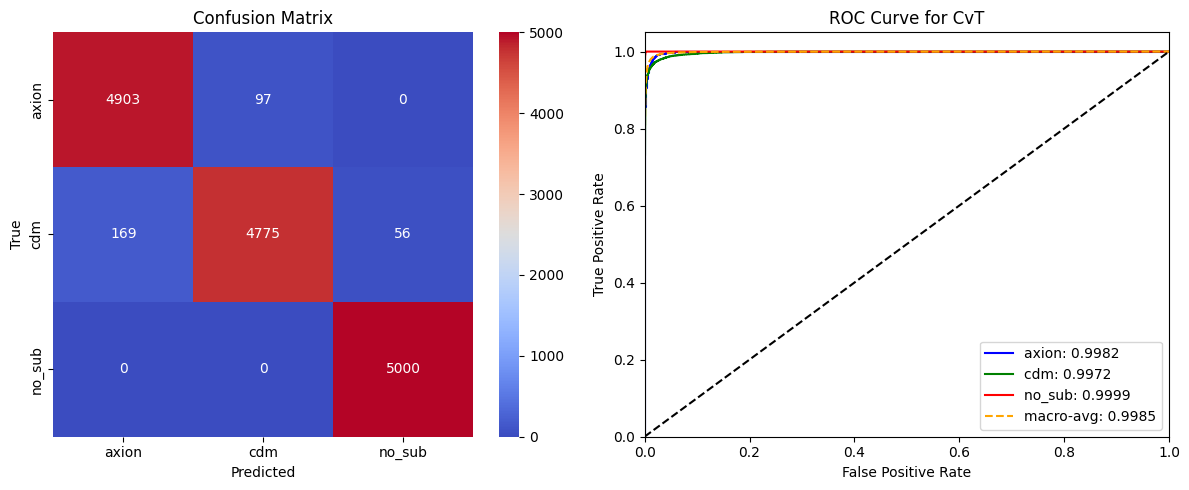

In [37]:
# Evaluate the model
evaluate_model(cvt, criterion, 'CvT')

#### Lensformer
- All classes' definitions below are copied directly from this [GitHub repository](https://github.com/ML4SCI/DeepLense/tree/main/Physics_Informed_Transformers_For_Dark-Matter_Morphology_Lucas_Jose) belongs to DeepLense.

In [38]:
# Lensformer
class Flatten(nn.Module):
    """
    This module flattens the input tensor into a 2D tensor with a fixed
    number of neurons (elements) in the second dimension.

    Args:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Attributes:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Returns:
        Flattened tensor with shape `[batch_size, num_neurons_flatten]`.
    """

    def __init__(self, num_neurons_flatten: int):
        # Initialize the superclass
        super(Flatten, self).__init__()
        self.num_neurons_flatten = num_neurons_flatten

    def forward(self, x: Tensor) -> Tensor:
        # Flatten the tensor to the specified number of neurons
        return x.contiguous().view(-1, self.num_neurons_flatten)
    
class FeedForward(nn.Module):

    def __init__(
        self,
        in_features: int,
        out_features: int,
        activation_function: nn.Module,
        num_hidden_neurons: int,
        num_hidden_layers: int,
        task_type: str,
        dropout: float = 0.1
    ):
        """
        Initializes a FeedForward neural network.
        The FeedForward class is a neural network module in PyTorch that represents a multi-layer
        feedforward neural network. The class takes as input the number of input features, output
        features, activation function, number of hidden neurons, number of hidden layers, and
        dropout rate. It initializes a list of PyTorch modules that defines the layers of the neural
        network, with a linear layer, activation function, and dropout layer for the first layer,
        and a sequence of linear, activation, and dropout layers for the subsequent hidden layers.
        The final layer is a linear layer followed by an activation function choosen by the task_type
        argument (Identity function if task_type='regression', Sigmoid if task_type='binary_classification'
        or Softmax if task_type='multi_classification'). The forward method of the class takes an input
        tensor and applies each layer in the list of PyTorch modules in sequence to produce an output
        tensor, which represents the output of the feedforward neural network.

        Args:
        -in_features (int): number of input features.
        -out_features (int): number of output features.
        -activation_function (nn.Module): activation function to be used in hidden layers.
        -final_activation_function (nn.Module): activation function to be used in final layer (depends on the task).
        -num_hidden_neurons (int): number of neurons in each hidden layer.
        -num_hidden_layers (int): number of hidden layers in the network.
        -task_type (str): Task to be solved by the neural network. Must be one of: 'regression', 'binary_classification' or 'multi_classification'.
        -dropout (float, optional): dropout probability. Defaults to 0.1.

        Attributes:
        -feedforward (nn.ModuleList): List with each layer of the neural network.
        """

        super(FeedForward, self).__init__()
        self.feedforward = nn.ModuleList()

        # add input layer
        self.feedforward.append(nn.Linear(in_features,num_hidden_neurons))
        self.feedforward.append(activation_function())
        self.feedforward.append(nn.Dropout(dropout))

        # add hidden layers
        for _ in range(num_hidden_layers):
            self.feedforward.append(nn.Linear(num_hidden_neurons,num_hidden_neurons))
            self.feedforward.append(activation_function())
            self.feedforward.append(nn.Dropout(dropout))

        # if task_type=='regression':
        #     self.final_activation_function = nn.Identity()
        # elif task_type=='binary_classification':
        #     self.final_activation_function = nn.Sigmoid()
        #     if out_features != 1:
        #         raise ValueError("task_type='binary_classification' only supports 1 neuron on the end of the neural network (out_features = 1). If you want to use more than one neuron, use 'multi_classification' instead.")
        # elif task_type=='multi_classification':
        #     self.final_activation_function = nn.Softmax(dim=1)
        # else:
        #     raise ValueError("task_type must be either of 'regression','binary_classification' or 'multi_classification'.")

        # add output layer
        self.feedforward.append(nn.Linear(num_hidden_neurons, out_features))
        # self.feedforward.append(self.final_activation_function)  # My training loop will account for Softmax later on

    def forward(self,x: Tensor) -> Tensor:
        """
        Computes the forward pass of the feedforward neural network.
        Args:
        x (Tensor): input tensor of shape [batch_size, in_features]
        Returns:
        Tensor: output tensor of shape [batch_size, out_features]
        """

        for layer in self.feedforward:
            x = layer(x)
            
        return x
    
class ShiftedPatchTokenization(nn.Module):
    """
    This module performs shifted patch tokenization on input images,
    generating patches with positional encodings for use in transformer models.

    Attributes:
        embed_dim (int): The dimension of the output embedding.
        image_width (int): Width of the input image.
        image_height (int): Height of the input image.
        patch_width (int): Width of each patch.
        patch_height (int): Height of each patch.
        device (torch.device): The device to use for computation.
        num_patches (int): The total number of patches generated from an image.
        delta_x (int): The amount to shift along the x-axis.
        delta_y (int): The amount to shift along the y-axis.
        total_channels (int): The total number of channels in the output tensor.
        projection (nn.Conv2d): Conv2D layer for patch projection.
        layer_norm (nn.LayerNorm): Layer normalization.
        cls_token (nn.Parameter): Token for class.
        positional_encoding (nn.Parameter): Positional encoding for patches.
    """

    def __init__(
        self,
        image_size: Union[int, Tuple[int, int]],
        patch_size: Union[int, Tuple[int, int]],
        embed_dim: int,
        in_channels: int,
        device: torch.device
    ):

        """
        Initializes the ShiftedPatchTokenization module.

        Args:
            image_size (Union[int, Tuple[int, int]]): Size of the input image. If an integer, it is assumed to be square-shaped.
            patch_size (Union[int, Tuple[int, int]]): Size of each patch. If an integer, it is assumed to be square-shaped.
            embed_dim (int): Dimension of the output embedding.
            in_channels (int): Number of channels in the input image.
            device (torch.device): Device to use for computation.

        Raises:
            ValueError: If the image dimensions are not divisible by the patch dimensions.
        """

        super(ShiftedPatchTokenization, self).__init__()

        # If image_size or patch_size is an integer, convert it to a tuple with equal width and height
        if type(image_size) == int:
            image_size = (image_size, image_size)
        if type(patch_size) == int:
            patch_size = (patch_size, patch_size)

        self.embed_dim = embed_dim
        self.image_width, self.image_height = image_size
        self.patch_width, self.patch_height = patch_size
        self.device = device

        # Check if the image dimensions are divisible by the patch dimensions
        if self.image_width % self.patch_width != 0 or self.image_height % self.patch_height != 0:
            raise ValueError("The image's width must be divisible by the patche's width and the image's height, by the patch's height")

        # Calculate the number of patches
        self.num_patches = int((self.image_width // self.patch_width) * (self.image_height // self.patch_height))

        # Set the translation amounts
        self.delta_x = self.patch_width // 2
        self.delta_y = self.patch_height // 2

        # Set the total number of channels for the output tensor
        self.num_transformations = 4
        self.total_channels = in_channels * (self.num_transformations + 1)

        # Define the projection layer
        self.projection = nn.Conv2d(
            in_channels=self.total_channels,
            out_channels=self.embed_dim,
            kernel_size=(self.patch_width, self.patch_height),
            stride=(self.patch_width, self.patch_height)
        )

        # Define the layer normalization layer
        self.layer_norm = nn.LayerNorm(self.embed_dim)

        # Define the CLS token
        self.cls_token = nn.Parameter(torch.zeros((1, 1, self.embed_dim)))

        # Define the positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros((1, 1 + self.num_patches, self.embed_dim)))

    def translate_image(self, image: Tensor, delta_x: int, delta_y: int, device: torch.device):
        """
        Translates an image by specified amounts along the x and y axes.

        Args:
            image (Tensor): Input image tensor.
            delta_x (int): Shift amount along the x-axis.
            delta_y (int): Shift amount along the y-axis.
            device (torch.device): Device to use for computation.

        Returns:
            Tensor: Translated image.
        """

        translated_image = transforms.functional.affine(image, angle=0, translate=(delta_x, delta_y), fill=0, scale=1, shear=0)
        translated_image = translated_image.to(device)

        return translated_image

    def get_num_patches(self):
        """
        Gets the total number of patches that would be created from an image.

        Returns:
            int: The total number of patches.
        """

        return self.num_patches

    def forward(self, image: Tensor) -> Tensor:
        """
        Performs the forward pass, tokenizing the image into patches and adding positional encodings.

        Args:
            image (Tensor): A tensor representing an image, of shape (batch_size, in_channels, image_height, image_width).

        Returns:
            Tensor: A tensor of tokenized image patches, of shape (batch_size, num_patches+1, embed_dim).
        """

        batch_size = image.size(0)

        # generate shifted versions of the image
        shift_left_up = self.translate_image(image, -self.delta_x, -self.delta_y,self.device)
        shift_right_up = self.translate_image(image, self.delta_x, -self.delta_y,self.device)
        shift_left_down = self.translate_image(image, -self.delta_x, self.delta_y,self.device)
        shift_right_down = self.translate_image(image, self.delta_x, self.delta_y,self.device)

        # concatenate the original image with its shifted versions
        concatenated_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        # project the concatenated image onto a lower-dimensional embedding
        projected_patches = self.projection(concatenated_images)
        patches = projected_patches.flatten(2)
        patches = patches.transpose(1, 2)

        patches.to(self.device)

        # apply layer normalization to the patches
        patches = self.layer_norm(patches)

        # append a learnable "class token" to the beginning of the patch sequence
        cls = self.cls_token.expand(batch_size, -1, -1)
        patches = torch.cat((cls, patches), dim=1)

        patches.to(self.device)

        # add learnable positional encodings to the patches
        patches = patches + self.positional_encoding

        return patches
    
class MultiLocallySelfAttention(nn.Module):
    """
    Implements a MultiLocallySelfAttention layer, which is a specialized form of multi-head self-attention
    designed to attend over local patches of an image.

    Attributes:
        embed_dim (int): Embedding dimensionality of the input.
        num_heads (int): Number of attention heads.
        num_patches (int): Number of patches in the image.
        dropout (float): Dropout rate for regularization.
        device (torch.device): Device to run the computations on.
        attn_mask (torch.Tensor): Attention mask for self-attention operation.
        mha (nn.MultiheadAttention): Standard multi-head attention layer.
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_patches: int,
        device: torch.device,
        dropout: float = 0.1
    ):
        """
        Initializes the MultiLocallySelfAttention layer.

        Args:
            embed_dim (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            num_patches (int): Number of patches in the image.
            device (torch.device): Device to run the computations on.
            dropout (float): Dropout rate for regularization. Default is 0.1.

        """

        super().__init__()

        # Store layer parameters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.dropout = dropout
        self.device = device

        # Initialize attention mask (a lower triangular matrix with True values)
        self.attn_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attn_mask = self.attn_mask.to(device)

        # Initialize multi-head attention layer
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)

    def forward(self, key: Tensor, query: Tensor, value: Tensor) -> Tensor:
        """
        Performs the forward pass through the MultiLocallySelfAttention layer.

        Args:
            key (Tensor): The key tensor for attention mechanism.
            query (Tensor): The query tensor for attention mechanism.
            value (Tensor): The value tensor for attention mechanism.

        Returns:
            Tensor: The output tensor after applying multi-head attention.
        """

        # Apply multi-head attention
        x, _ = self.mha(query, key, value, attn_mask=self.attn_mask)

        return x
    
class TransformerLSABlock(nn.Module):
    """
    Implements a TransformerLSABlock, a building block for transformer models designed
    to work on image patches. This block contains multi-locally self-attention,
    feedforward network, and layer normalization components.

    Attributes:
        mlsa (MultiLocallySelfAttention): MultiLocallySelfAttention layer.
        first_norm (nn.LayerNorm): First layer normalization.
        feedforward (FeedForward): FeedForward neural network layer.
        second_norm (nn.LayerNorm): Second layer normalization.
        dropout_layer (nn.Dropout): Dropout layer for regularization.
        device (torch.device): Device to run the computations on.
        temperature (nn.Parameter): Temperature parameter for attention mechanism.
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_patches: int,
        num_hidden_neurons: int,
        activation_function: nn.Module,
        device: torch.device,
        dropout: float = 0.1
    ):
        """
        Initializes the TransformerLSABlock layer.

        Args:
            embed_dim (int): The dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            num_patches (int): Number of patches in the image.
            num_hidden_neurons (int): Number of neurons in the hidden layer of the feedforward network.
            activation_function (nn.Module): Activation function used in the feedforward network.
            device (torch.device): Device to run the computations on.
            dropout (float, optional): Dropout rate for regularization. Default is 0.1.
        """

        super().__init__()

        # initialize the multi-locally self-attention layer
        self.mlsa = MultiLocallySelfAttention(embed_dim, num_heads, num_patches, device, dropout)

        # initialize the first layer normalization
        self.first_norm = nn.LayerNorm(embed_dim)

        # initialize the feedforward network
        self.feedforward = FeedForward(
            embed_dim,
            embed_dim,
            activation_function,
            num_hidden_neurons,
            num_hidden_layers=1,
            task_type='regression',
            dropout=dropout
        )

        # initialize the second layer normalization
        self.second_norm = nn.LayerNorm(embed_dim)

        # initialize the dropout layer
        self.dropout_layer = nn.Dropout(dropout)

        # the device to store the tensors on
        self.device = device

        # initialize temperature parameter (a scalar used to divide the queries)
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, key: torch.Tensor, query: Union[torch.Tensor, None] = None, value: Union[torch.Tensor, None] = None) -> torch.Tensor:
        """
        Performs the forward pass through the TransformerLSABlock layer.

        Args:
            key (Tensor): The key tensor for the attention mechanism.
            query (Union[Tensor, None], optional): The query tensor for the attention mechanism.
                                                  If None, it defaults to the key tensor divided by temperature.
                                                  Default is None.
            value (Union[Tensor, None], optional): The value tensor for the attention mechanism.
                                                   If None, it defaults to the key tensor.
                                                   Default is None.

        Returns:
            Tensor: The output tensor after applying multi-locally self-attention,
                    layer normalization, feedforward network, and dropout.
        """
        
        # Prepare key, query, and value tensors
        key = key.to(self.device)
        if query is None:
            query = (key / self.temperature).to(self.device)
        if value is None:
            value = key.to(self.device)

        # apply multi-locally self-attention
        value = value + self.mlsa(key, query, value)

        # apply first layer normalization
        value = self.first_norm(value)

        # apply feedforward network
        value = value + self.feedforward(value)

        # apply second layer normalization
        value = self.second_norm(value)

        # apply dropout
        value = self.dropout_layer(value)

        return value
    
class RelativisticPhysicalInformedEncoder(nn.Module):
    """
    A PyTorch module to perform inverse gravitational lensing using the Singular Isothermal Sphere (SIS) model.

    Attributes:
        pixel_scale (float): The scale of each pixel in the image, often in arcseconds per pixel.
        profile_size (int): The size of the image profile.
        half_profile_size (int): Half of the profile size.
        num_patches (int): Number of patches.
        embed_dim (int): Dimension of the embedding.
        num_heads (int): Number of heads in the transformer.
        num_hidden_neurons (int): Number of hidden neurons.
        eps (float): Float number used to avoid division by zero.
        transformer_activation_function (nn.Module): Activation function used in the transformer.
        num_transformer_blocks (int): Number of transformer blocks.
        device (torch.device): Device to which tensors will be moved.
        transformer (nn.ModuleList): List of transformer blocks.
        num_neurons_flatten (int): Number of neurons in the Flatten layer.
        grid_x (Tensor): Grid of x coordinates.
        grid_y (Tensor): Grid of y coordinates.
        flat_grid_x (Tensor): Flattened grid of x coordinates.
        flat_grid_y (Tensor): Flattened grid of y coordinates.
    """

    def __init__(
        self,
        image_size: int,
        patch_size: int ,
        embed_dim: int,
        num_patches: int,
        num_heads: int,
        num_hidden_neurons: int,
        transformer_activation_function: nn.Module,
        num_transformer_blocks: int,
        device: torch.device,
        dropout: float = 0.1,
        pixel_scale:float =0.101,
        k_min: float = 0.8,
        k_max: float = 1.2,
        eps: float = 1e-8
    ):

        """
        Initialize the module.

        Args:
            image_size (int): The size of the image.
            patch_size (int): The size of each patch.
            embed_dim (int): The embedding dimension.
            num_patches (int): The number of patches.
            num_heads (int): The number of heads in the transformer.
            num_hidden_neurons (int): The number of hidden neurons.
            transformer_activation_function (nn.Module): The activation function used in the transformer.
            num_transformer_blocks (int): The number of transformer blocks.
            device (torch.device): The device to which tensors will be moved.
            dropout (float, optional): The dropout rate. Defaults to 0.1.
            pixel_scale (float, optional): The scale of each pixel in the image, often in arcseconds per pixel. Defaults to 0.101.
            k_min (float, optional): Minimum value of the potential correction parameter.  Defaults to 0.8.
            k_max (float, optional): Maximum value of the potencial correction parameter.  Defaults to 1.2.
            eps (float): Float number used to avoid division by zero. Defaluts to 1e-8.
        """

        super(RelativisticPhysicalInformedEncoder, self).__init__()

        # Initialize variables
        self.pixel_scale = pixel_scale
        self.profile_size = image_size
        self.half_profile_size = self.profile_size // 2
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.transformer_activation_function = transformer_activation_function
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.k_min = k_min
        self.k_max = k_max
        self.eps = eps

        # Create an empty list for the transformer blocks
        self.transformer = nn.ModuleList()

        # Calculate the number of neurons for the Flatten layer
        self.num_neurons_flatten = (self.num_patches + 1) * embed_dim

        # Create an empty list for the transformer blocks
        self.transformer = nn.ModuleList()

        # Create a for loop that iterates over the number of transformer blocks

        for _ in range(num_transformer_blocks):
            # Add a TransformerLSABlock to the transformer list
            self.transformer.append(
                TransformerLSABlock(
                    embed_dim,
                    num_heads,
                    self.num_patches,
                    num_hidden_neurons,
                    transformer_activation_function,
                    device,
                    dropout
                )
            )

        # Create a compressor (FeedFoward) compress the size of num_neurons_flatten
        self.transformer.append(nn.Flatten())
        self.transformer.append(nn.Linear(self.num_neurons_flatten, self.profile_size * self.profile_size))
        self.transformer.append(nn.Sigmoid())

        # Create a grid for image coordinates
        x_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size - 1, self.profile_size) * self.pixel_scale
        y_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size - 1, self.profile_size) * self.pixel_scale
        self.grid_x, self.grid_y = torch.meshgrid(x_coordinates, y_coordinates)
        self.flat_grid_x = self.grid_x.flatten().to(self.device)
        self.flat_grid_y = self.grid_y.flatten().to(self.device)

    def forward(self, input_images: Tensor, patches: Tensor)->Tensor:
        """
        Forward pass through the module.

        Args:
            input_images (torch.Tensor): The input images.
            patches (torch.Tensor): The patches extracted from the images.

        Returns:
            output_images (torch.Tensor): The output images after inverse gravitational lensing.
        """

        # Get the batch size from the input images
        batch_size = input_images.shape[0]

        # Generate k using the sequential model
        for i, layer in enumerate(self.transformer):
            if i == 0:
                k_sigmoid = layer(patches)
            else:
                k_sigmoid = layer(k_sigmoid)

        # Reshape k_sigmoid to have shape [batch_size, profile_size, profile_size]
        k_sigmoid = k_sigmoid.view(-1, self.profile_size, self.profile_size)

        # Flatten k_sigmoid to match the shape of non_zero_x and non_zero_radius
        k_sigmoid_flat = k_sigmoid.view(-1, self.profile_size*self.profile_size)

        # Bias and Scaling
        k_sigmoid_flat = self.k_min + (self.k_max-self.k_min) * k_sigmoid_flat

        # Flatten the input images for easier indexing
        flat_input_images = input_images.view(batch_size, -1)

        # Create a mask for non-zero coordinates in the grid
        non_zero_mask = (self.flat_grid_x != 0) | (self.flat_grid_y != 0)

        # Select only the non-zero indices to match with non_zero_x and non_zero_radius
        k_sigmoid_non_zero = k_sigmoid_flat[:, non_zero_mask]

        # Get the shape of k_sigmoid_non_zero
        shape_k_sigmoid_non_zero = k_sigmoid_non_zero.shape

        # Reshape k to have a batch dimension compatible for broadcasting
        k = k_sigmoid_non_zero.view(shape_k_sigmoid_non_zero[0], 1, 1, shape_k_sigmoid_non_zero[1])

        # Apply the mask to get non-zero coordinates
        non_zero_x = self.flat_grid_x[non_zero_mask]
        non_zero_y = self.flat_grid_y[non_zero_mask]

        # Calculate the radius for non-zero coordinates
        non_zero_radius = torch.sqrt(non_zero_x ** 2 + non_zero_y ** 2)

        # Expand dimensions for broadcasting
        non_zero_radius = non_zero_radius[None, None, None, :]

        # Compute shifted coordinates based on the Gravitational Lens Equation to SIS model
        shifted_x = (non_zero_x[None, None, None, :] - k * non_zero_x[None, None, None, :] / non_zero_radius)
        shifted_y = (non_zero_y[None, None, None, :] - k * non_zero_y[None, None, None, :] / non_zero_radius)

        # Convert shifted coordinates to indices in the image grid
        shifted_x_idx = torch.round(shifted_x / self.pixel_scale + self.half_profile_size).long()
        shifted_y_idx = torch.round(shifted_y / self.pixel_scale + self.half_profile_size).long()

        # Initialize the output image tensor and flatten it
        output_images = torch.zeros(batch_size, self.profile_size, self.profile_size).to(self.device)
        flat_output_images = output_images.view(batch_size, -1)

        # Calculate 1D indices from shifted_x_idx and shifted_y_idx
        one_d_indices = shifted_x_idx * self.profile_size + shifted_y_idx

        # Flatten the input images for easier indexing
        flat_input_images = input_images.view(batch_size, -1)

        # Get the current values at the shifted positions in the flat output images
        output_values_at_shifted_positions = flat_output_images.gather(1, one_d_indices.view(batch_size, -1))

        # Get the corresponding values from the original positions in the flat input images
        input_values_at_original_positions = flat_input_images[:, non_zero_mask]

        # Update the output image based on the algorithm
        updated_values = torch.where(
            output_values_at_shifted_positions == 0,
            input_values_at_original_positions,
            (output_values_at_shifted_positions + input_values_at_original_positions) / 2
        )

        # Assign the updated values back to the flat output images
        flat_output_images.scatter_(1, one_d_indices.view(batch_size, -1), updated_values)

        # Reshape the flat output images back to their original shape
        output_images = flat_output_images.view(batch_size, self.profile_size, self.profile_size)


        # Normalize the output images
        max_values, _ = output_images.max(dim=1, keepdim=True)
        max_values, _ = max_values.max(dim=2, keepdim=True)
        output_images = output_images / (max_values + self.eps)

        return output_images
    
class Lensformer(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: int,
        embed_dim: int,
        in_channels: int,
        num_classes: int,
        num_heads: int,
        num_hidden_neurons: int,
        num_hidden_layers: int,
        transformer_activation: nn.Module,
        feedforward_activation: nn.Module,
        num_transformer_blocks: int,
        device: torch.device,
        dropout_rate: float = 0.1
    ):
        """
        Initializes Lensiformer, a Relativistic Physics-Informed Vision Transformer (PIViT) Architecture for Dark Matter Morphology.

        Args:
            image_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each image patch (assumed square).
            embed_dim (int): Dimension of the embedding space.
            in_channels (int): Number of input channels.
            num_classes (int): Number of target classes.
            num_heads (int): Number of attention heads.
            num_hidden_neurons (int): Number of neurons in hidden layers.
            num_hidden_layers (int): Number of hidden layers.
            transformer_activation (nn.Module): Activation function for transformer blocks.
            feedforward_activation (nn.Module): Activation function for feedforward layers.
            num_transformer_blocks (int): Number of transformer blocks.
            device (torch.device): Computational device (CPU/GPU).
            dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
        """

        super(Lensformer, self).__init__()

        # Initialize parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.num_hidden_layers = num_hidden_layers
        self.transformer_activation = transformer_activation
        self.feedforward_activation = feedforward_activation
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.dropout_rate = dropout_rate

        # Initialize modules
        self.initial_tokenizer = ShiftedPatchTokenization(image_size, patch_size, embed_dim, in_channels, device)
        self.secondary_tokenizer = ShiftedPatchTokenization(image_size, patch_size, embed_dim, in_channels, device)
        self.encoder = RelativisticPhysicalInformedEncoder(
            image_size,
            patch_size,
            embed_dim,
            self.initial_tokenizer.get_num_patches(),
            num_heads,
            num_hidden_neurons,
            transformer_activation,
            num_transformer_blocks,
            device
        )

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerLSABlock(
                embed_dim,
                num_heads,
                self.initial_tokenizer.get_num_patches(),
                num_hidden_neurons,
                transformer_activation,
                device,
                dropout_rate
            ) for _ in range(num_transformer_blocks)
        ])

        # Flatten and FeedForward layers
        self.flatten_layer = Flatten((self.initial_tokenizer.get_num_patches() + 1) * embed_dim)
        self.feedforward_layer = FeedForward(
            self.flatten_layer.num_neurons_flatten,
            num_classes,
            feedforward_activation,
            num_hidden_neurons,
            num_hidden_layers,
            task_type='multi_classification',
            dropout=dropout_rate
        )

    def invert_lens(self, images: Tensor) -> Tensor:
        batch_size = images.size(0)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)

        return lens_corrected_images


    def forward(self, images: Tensor) -> Tensor:
        """
        Forward pass through the Physics-Informed Vision Transformer.

        Args:
            images (Tensor): Input images with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Model predictions with shape (batch_size, num_classes).
        """

        batch_size = images.size(0)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)
        lens_corrected_patches = self.secondary_tokenizer(lens_corrected_images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            initial_patches = block(key=initial_patches, value=lens_corrected_patches)

        # Flatten the patches
        flattened_patches = self.flatten_layer(initial_patches)

        # Generate final predictions
        final_predictions = self.feedforward_layer(flattened_patches)

        return final_predictions
    
lensformer = Lensformer(
    image_size=64,
    patch_size=32,
    embed_dim=384,
    in_channels=1,
    num_classes=3,
    num_heads=16,
    num_hidden_neurons=64,
    num_hidden_layers=3,
    transformer_activation=nn.ELU,
    feedforward_activation=nn.ELU,
    num_transformer_blocks=1,
    device=device
).to(device)

lensformer

Lensformer(
  (initial_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(5, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (secondary_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(5, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): RelativisticPhysicalInformedEncoder(
    (transformer): ModuleList(
      (0): TransformerLSABlock(
        (mlsa): MultiLocallySelfAttention(
          (mha): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
          )
        )
        (first_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (feedforward): FeedForward(
          (feedforward): ModuleList(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): ELU(alpha=1.0)
            (2): Dropout(

- We remove some `final_activation_function` layers in Lensformer, because `nn.CrossEntropyLoss()` in our training loop takes in logits, not probability from `nn.Softmax()`.

In [39]:
optimizer = optim.Adam(lensformer.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()

# Train the model
history_lensformer, lensformer = train_model(lensformer, criterion, optimizer, scheduler, num_epochs=100, save_path='./lensformer.pt')

Epoch [1/100], Train Loss: 0.7674, Train Acc: 0.6600, Val Loss: 0.3473, Val Acc: 0.8773, LR: [1e-05]
Epoch [2/100], Train Loss: 0.3335, Train Acc: 0.8713, Val Loss: 0.2698, Val Acc: 0.8896, LR: [9.25437951083198e-06]
Epoch [3/100], Train Loss: 0.2983, Train Acc: 0.8811, Val Loss: 0.2412, Val Acc: 0.9009, LR: [9.415761846635176e-06]
Epoch [4/100], Train Loss: 0.2749, Train Acc: 0.8893, Val Loss: 0.2627, Val Acc: 0.8997, LR: [9.475983270650536e-06]
Epoch [5/100], Train Loss: 0.2644, Train Acc: 0.8931, Val Loss: 0.2206, Val Acc: 0.9122, LR: [9.430706204728565e-06]
Epoch [6/100], Train Loss: 0.2561, Train Acc: 0.8963, Val Loss: 0.2238, Val Acc: 0.9084, LR: [9.51973606572585e-06]
Epoch [7/100], Train Loss: 0.2446, Train Acc: 0.9010, Val Loss: 0.2282, Val Acc: 0.9091, LR: [9.512843891198074e-06]
Epoch [8/100], Train Loss: 0.2380, Train Acc: 0.9050, Val Loss: 0.2023, Val Acc: 0.9178, LR: [9.503437142100435e-06]
Epoch [9/100], Train Loss: 0.2272, Train Acc: 0.9095, Val Loss: 0.2023, Val Acc: 0

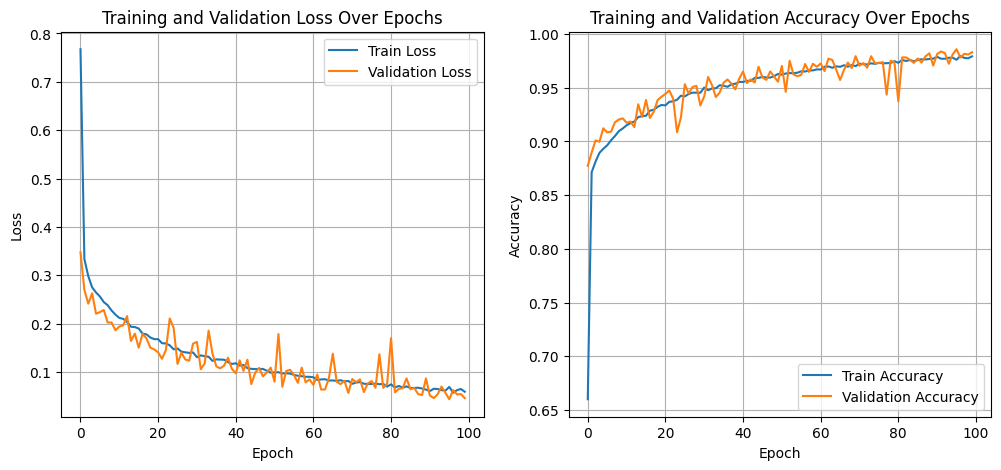

In [40]:
# Training progress of Lensformer
plot_results(history_lensformer)

In [41]:
# Load checkpoint
lensformer.load_state_dict(torch.load('./lensformer.pt'))

<All keys matched successfully>

Test Loss: 0.0446
Accuracy: 0.9845
ROC AUC: 0.9991


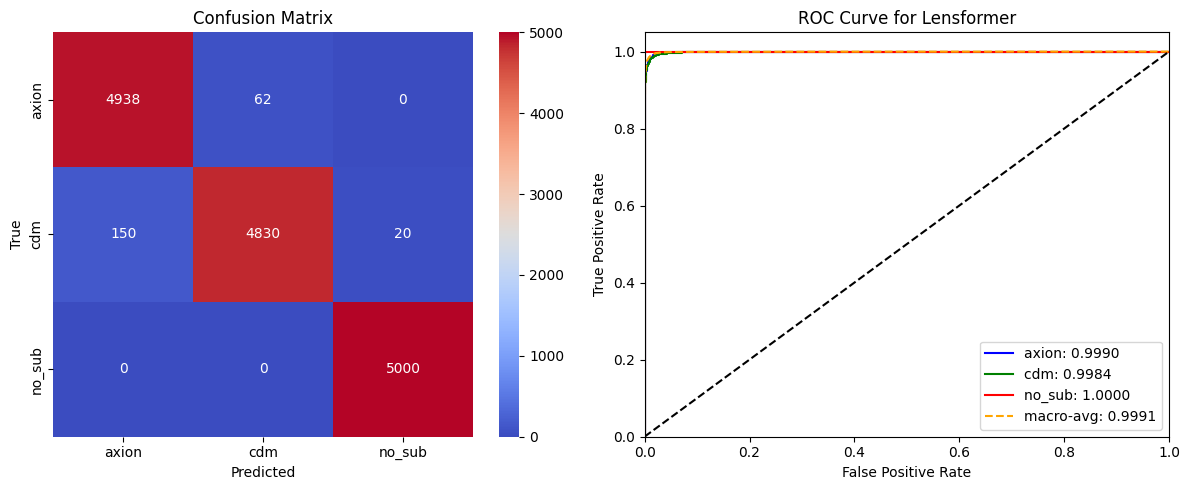

In [42]:
# Evaluate the model
evaluate_model(lensformer, criterion, 'Lensformer')

#### Comparison

In [43]:
def count_parameters(model: nn.Module) -> int:
    # Count the number of trainable parameters
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Finding the value in M
    num_parameters = num_parameters / 1e6

    return num_parameters

CNN has 0.51M trainable parameters.
ResNet18 has 11.17M trainable parameters.
EfficientNet_B0 has 4.01M trainable parameters.
ViT has 13.40M trainable parameters.
CvT has 13.09M trainable parameters.
Lensformer has 13.24M trainable parameters.


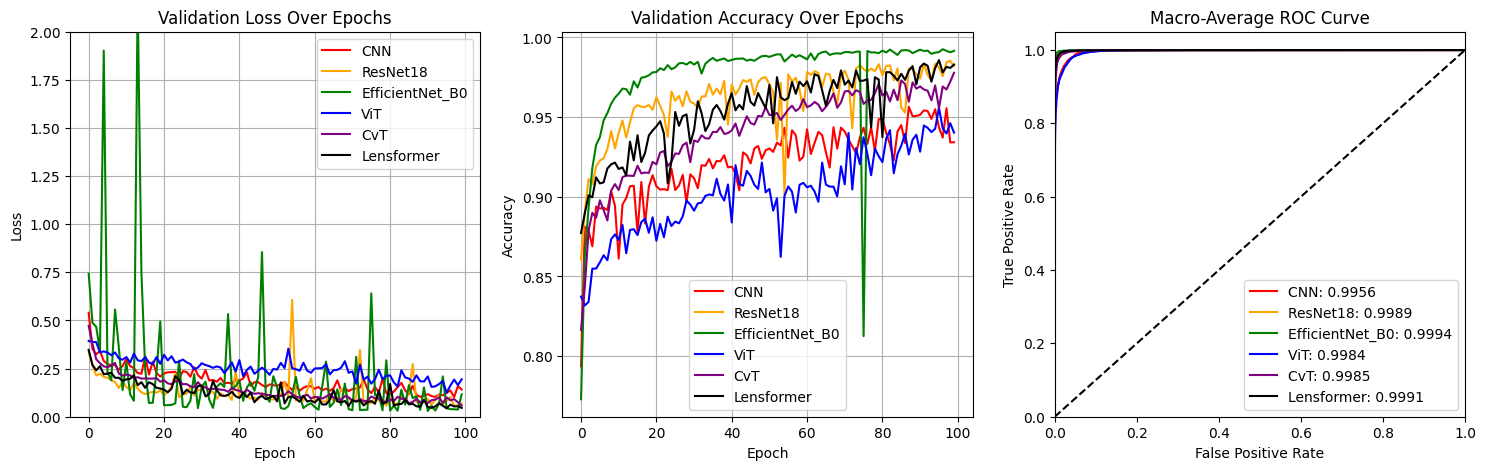

In [44]:
# Lists of all histories and models
names = ['CNN', 'ResNet18', 'EfficientNet_B0', 'ViT', 'CvT', 'Lensformer']
history_list = [history_cnn, history_resnet, history_effnet, history_v, history_cvt, history_lensformer]
model_list = [cnn, resnet18, effnet, v, cvt, lensformer]
colors = ['red', 'orange', 'green', 'blue', 'purple', 'black']

# Total number of parameters in each model
for i, model in enumerate(model_list):
    print(f'{names[i]} has {count_parameters(model):.2f}M trainable parameters.')

# Visualization
plt.figure(figsize=(18, 5))

# Plot validation loss for each model
plt.subplot(1, 3, 1)
for i, history in enumerate(history_list):
    plt.plot(history['val_loss'], color=colors[i], label=names[i])
    plt.ylim([0.0, 2.0])
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Plot validation accuracy for each model
plt.subplot(1, 3, 2)
for i, history in enumerate(history_list):
    plt.plot(history['val_acc'], color=colors[i], label=names[i])
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Plot ROC curve for each model
plt.subplot(1, 3, 3)
for i, model in enumerate(model_list):
    model.eval()
    y_pred_probs = []
    y_true = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)

            y_pred_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Average ROC AUC score
    avg_roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovo')

    avg_fpr, avg_tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(avg_fpr, avg_tpr, color=colors[i], label=f'{names[i]}: {avg_roc_auc:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Macro-Average ROC Curve')
plt.legend(loc='lower right')

plt.show()